# Fashion Classification on DeepFashion dataset using transfer learning

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import cv2
import pretrainedmodels
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

- Check availability of GPU, luckily I can train the model on my gaming GPU, but on a small scale.

In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Sat May 13 18:14:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070       WDDM | 00000000:10:00.0  On |                  N/A |
|  0%   46C    P8               23W / 270W|   1728MiB /  8192MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset preparation

- For the dataset, I am using the [DeepFashion dataset](https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) provided by CUHK.

In [4]:
with open('DF/list_category_img.txt', 'r') as f:
    lines = f.readlines()
    
df_df_sub = pd.DataFrame([l.split() for l in lines[2:]], columns=lines[1].split())

In [5]:
with open('DF/list_category_cloth.txt', 'r') as f:
    lines = f.readlines()

df_df_sup = pd.DataFrame([l.split() for l in lines[2:]], columns=lines[1].split())
df_df_sup['category_num'] = list(range(1, len(df_df_sup) + 1))
df_df_sup['category_num'] = df_df_sup['category_num'].astype(str)

- The dataset contains 46 detailed categories of clothes, but the author provided a mapping to 3 main types. 

- I will use the mapping to limit the training labels to three classes, since it is hard to train a model predicting too many classes on a small number of data.

In [6]:
df_mapping = dict(zip(df_df_sup.category_num, df_df_sup.category_type))

In [7]:
df_df_sub['label'] = df_df_sub['category_label'].map(df_mapping)

In [8]:
all_images = list()
for folder in os.listdir('DF/img/'):
    for file in os.listdir(f'DF/img/{folder}'):
        all_images.append(f'img/{folder}/{file}')

In [9]:
df_df_sub = df_df_sub[df_df_sub.image_name.isin(all_images)]

- Show the proportion of each class.

In [10]:
df_df_sub.label.value_counts(normalize=True)

label
1    0.483176
3    0.312903
2    0.203920
Name: proportion, dtype: float64

- Since the complete dataset is too big for training, I am only using 2\% of it. The default sample seed is 42.

In [31]:
df_model = df_df_sub.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.02, random_state=42))

- Make sure the sample is stratified. 

- The subset for training contains 5783 images.

In [32]:
df_model.label.value_counts(normalize=True)

label
1    0.483140
3    0.312986
2    0.203873
Name: proportion, dtype: float64

In [33]:
len(df_model)

5783

Use one-hot encoding on labels.

In [34]:
ohe = OneHotEncoder(sparse=False).fit(df_model[['label']])
labels_onehot = ohe.transform(df_model[['label']])
labels_onehot = pd.DataFrame(labels_onehot, index=df_model.index, columns=ohe.categories_)

## Custom dataset definition

- The iamges are transformed into shape of (224, 224, 3) as input of ResNet model.

- To add to the generalization of model, I add augmentations to the images for training (vertical and horizontal flipping with probability of 50\%).

- The normalization parameters are referenced from the Github repo for [pretrained models](https://github.com/Cadene/pretrained-models.pytorch#torchvision).

In [15]:
class DeepFashionDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, train):
        self.image_paths = image_paths
        self.labels = labels
        self.train = train
        
        if self.train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=.5),
                transforms.RandomVerticalFlip(p=.5),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_path = self.image_paths['image_name'].iloc[index]
        image = cv2.imread(f'DF/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        label = torch.tensor(self.labels.iloc[index], dtype=torch.float32)
        
        return image, label

## Deep learning model definition

- I am using the ResNet50 model from [pretrained models](https://github.com/Cadene/pretrained-models.pytorch#torchvision).

- By default, the model will use a pretrained ResNet50 on ImageNet for feature extraction. For transfer learning, I am freezing all the parameters before the last linear layer, and replacing it with a classifier layer containing two sequences of linear layer, ReLU activation function, and dropout layer. The final output is a three-dimension tensor for label comparison.

In [16]:
class DeepFashionClassifier(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(DeepFashionClassifier, self).__init__()
        if pretrained:
            self.resnet = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.resnet = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad = False
        else:
            for param in self.resnet.parameters():
                param.requires_grad = True
                
        self.resnet.last_linear = torch.nn.Sequential(
            nn.Linear(self.resnet.last_linear.in_features, 256),
            nn.ReLU(),
            nn.Dropout(.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(.4),
            nn.Linear(128, 3)
        )
            
    def forward(self, x):
        y = self.resnet(x)
        return y

## Training utility functions

- The original data is split 90/10 into training and test data, with default seed 42.

- I am using a 5-fold cross validation on the training data due to insufficient training data.

In [17]:
def get_folds(images, labels, n_splits=5, split_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=.1, random_state=split_seed, stratify=labels)
    kf = StratifiedKFold(n_splits=n_splits)
    folds = list()
    for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train.to_numpy().argmax(1))):
        train_ids = X_train.index[train_index]
        valid_ids = X_train.index[valid_index]
        folds.append([train_ids.tolist(), valid_ids.tolist()])
        
    return X_train, X_test, y_train, y_test, folds

- Initialize optimizer, the weight decay is set to 1e-3 to balance bias and variance.

In [18]:
def get_optimizer(model, lr=1e-3, wd=1e-3):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

- Define training function, the common cross entropy loss is used as loss evaluation function.

In [19]:
def train_model(model, optim, train_loader, device):
    model.train()
    total = 0
    sum_loss = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    
    for images, labels in train_loader:
        batch_size = labels.shape[0]
        total += batch_size
        images = images.to(device)
        labels = labels.to(device)
        optim.zero_grad()
        outs = model(images)
        loss = loss_criterion(outs, labels)
        sum_loss += loss.item() * batch_size
        loss.backward()
        optim.step()
        
    return round(sum_loss / total, 5)

- The validation function returns both loss and accuracy.

In [20]:
def validate_model(model, validate_loader, device):
    model.eval()
    total = 0
    correct = 0
    sum_loss = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    
    for images, labels in validate_loader:
        batch_size = labels.shape[0]
        total += batch_size
        images = images.to(device)
        labels = labels.to(device)
        outs = model(images)
        loss = loss_criterion(outs, labels)
        sum_loss += loss.item() * batch_size
        out_argmax = outs.cpu().detach().numpy().argmax(1)
        label_argmax = labels.cpu().detach().numpy().argmax(1)
        correct += sum(out_argmax == label_argmax)
    
    return round(sum_loss / total, 5), round(correct / total, 5)

- Prediction function predicts on untrained data, returns both loss and accuracy.

In [21]:
def model_predict(model, X_test, y_test, batch_size=64):
    model.eval()
    test_dataset = DeepFashionDataset(X_test, y_test, train=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    print('Predicting test set...')
    
    total = 0
    correct = 0
    sum_loss = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss_criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    
    for images, labels in test_loader:
        total += batch_size
        images = images.to(device)
        labels = labels.to(device)
        outs = model(images)
        loss = loss_criterion(outs, labels)
        sum_loss += loss.item() * batch_size
        out_argmax = outs.cpu().detach().numpy().argmax(1)
        label_argmax = labels.cpu().detach().numpy().argmax(1)
        correct += sum(out_argmax == label_argmax)
        
    return round(sum_loss / total, 5), round(correct / total, 5)

- The training loop with cross validation, reports training loss, validation loss, validation accuracy every 5 epochs, returns each fold's results in a dictionary, also returns trained models of each fold.

In [22]:
def train_loop_cv(X_train, y_train, folds, epochs, batch_size=128, lr=1e-3, wd=1e-3):
    train_losses = dict()
    val_losses = dict()
    val_accs = dict()
    models = dict()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for i, fold in enumerate(range(len(folds))):
        print(f'Starting Fold {i + 1}...')
        
        train_idx = folds[fold][0]
        valid_idx = folds[fold][1]
        
        train_dataset = DeepFashionDataset(X_train.loc[train_idx], y_train.loc[train_idx], train=True)
        val_dataset = DeepFashionDataset(X_train.loc[valid_idx], y_train.loc[valid_idx], train=False)
        
        print('Read training data success!')
                
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        
        model = DeepFashionClassifier().to(device)
        optim = get_optimizer(model, lr, wd)
        
        train_losses[i+1] = list()
        val_losses[i+1] = list()
        val_accs[i+1] = list()
    
        for epoch in range(epochs):
            train_loss = train_model(model, optim, train_loader, device)
            val_loss, val_acc = validate_model(model, valid_loader, device)
            
            train_losses[i+1].append(train_loss)
            val_losses[i+1].append(val_loss)
            val_accs[i+1].append(val_acc)
            
            if epoch % 5 == 4:
                print(f"Epoch {epoch + 1}, train loss: {train_loss}, validation loss: {val_loss}, validation acc: {val_acc}")
                
        models[i+1] = model.to('cpu')
        
        # for model selection
        # break
    
    return train_losses, val_losses, val_accs, models

- The function plots training and validation loss on the same graph so I can inspect if the model is overfitting or underfitting.

In [23]:
def generate_loss_plots(data, n_splits=5):
    plt.style.use('fivethirtyeight')
    f, axs = plt.subplots(1, n_splits, figsize=(20, 5), sharey=True)
    for i, ax in enumerate(axs):
        if i == 0:
            ax.set_ylabel('Loss')
        ax.plot(data[0][i+1])
        ax.plot(data[1][i+1])
        ax.set_title(f'Fold {i + 1}')
        if i == n_splits - 1:
            ax.legend(['Train', 'Valid'])
    plt.show()

- The function visualizes the change of accurcy during training.

In [24]:
def generate_acc_plots(data, n_splits=5):
    plt.style.use('fivethirtyeight')
    f, axs = plt.subplots(1, n_splits, figsize=(20, 5), sharey=True)
    for i, ax in enumerate(axs):
        if i == 0:
            ax.set_ylabel('Accuracy')
        ax.plot(data[0][i+1])
        ax.set_title(f'Fold {i + 1}')
    plt.show()

## Training starts here

In [35]:
X_train, X_test, y_train, y_test, folds = get_folds(df_model[['image_name']], labels_onehot)

In [36]:
train_losses, val_losses, val_accs, models = train_loop_cv(X_train, y_train, folds, epochs=30)

Starting Fold 1...
Read training data success!
Epoch 5, train loss: 0.69979, validation loss: 0.62942, validation acc: 0.7464
Epoch 10, train loss: 0.67161, validation loss: 0.59477, validation acc: 0.76273
Epoch 15, train loss: 0.63766, validation loss: 0.58479, validation acc: 0.76369
Epoch 20, train loss: 0.61568, validation loss: 0.58271, validation acc: 0.76081
Epoch 25, train loss: 0.60964, validation loss: 0.58602, validation acc: 0.77137
Epoch 30, train loss: 0.62007, validation loss: 0.58952, validation acc: 0.76081
Starting Fold 2...
Read training data success!
Epoch 5, train loss: 0.72329, validation loss: 0.63056, validation acc: 0.72719
Epoch 10, train loss: 0.66348, validation loss: 0.61456, validation acc: 0.7464
Epoch 15, train loss: 0.64495, validation loss: 0.59891, validation acc: 0.74256
Epoch 20, train loss: 0.62973, validation loss: 0.57191, validation acc: 0.75985
Epoch 25, train loss: 0.61493, validation loss: 0.58197, validation acc: 0.74736
Epoch 30, train los

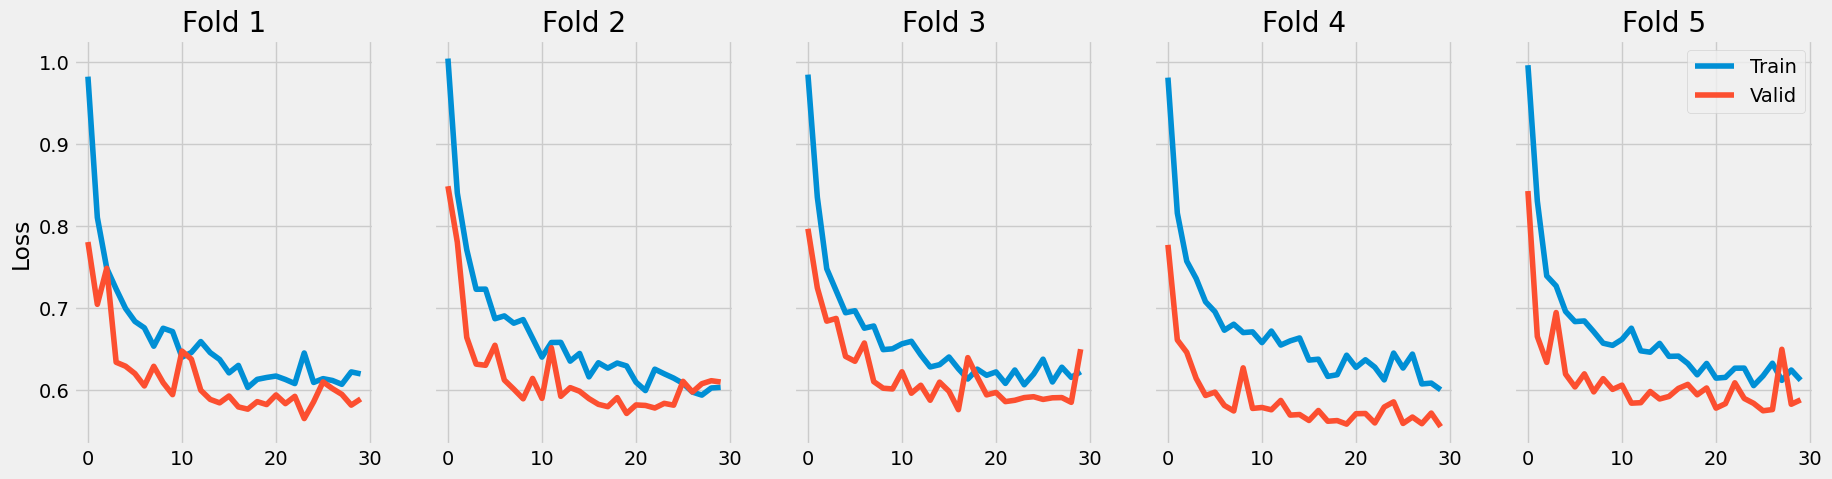

In [37]:
generate_loss_plots([train_losses, val_losses])

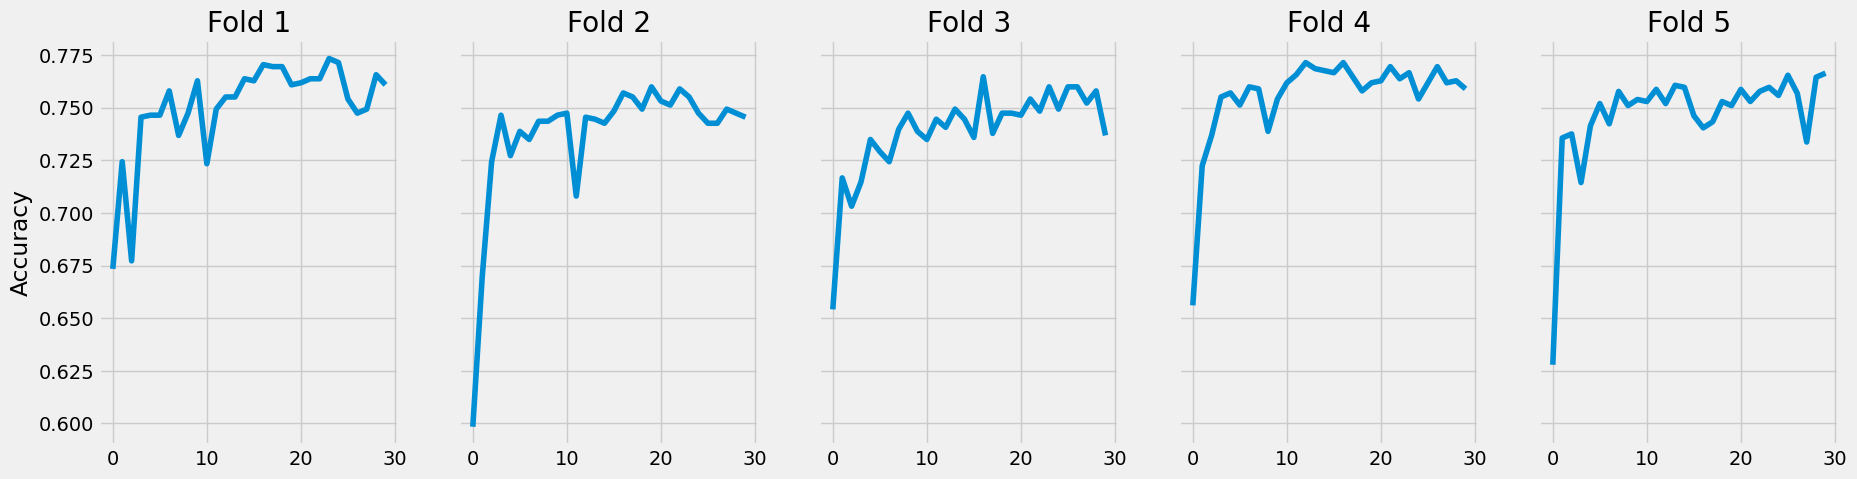

In [38]:
generate_acc_plots([val_accs])

- Make predictions on untrained data.

In [39]:
for model in models.values():
    test_loss, test_acc = model_predict(model, X_test, y_test, batch_size=128)
    print(f'Test loss: {test_loss}, Test acc: {test_acc}')

Predicting test set...
Test loss: 0.55999, Test acc: 0.69219
Predicting test set...
Test loss: 0.5709, Test acc: 0.69062
Predicting test set...
Test loss: 0.60634, Test acc: 0.67969
Predicting test set...
Test loss: 0.53771, Test acc: 0.71094
Predicting test set...
Test loss: 0.56321, Test acc: 0.71875


- Clear GPU cache for next round of training.

In [40]:
torch.cuda.empty_cache()